In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
# import constants as c
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
synthfirm_all = read_csv('outputs/synthetic_firms.csv')
region_map = gpd.read_file('inputs/Austin_freight.geojson')
mesozone_id_lookup = read_csv('inputs/zonal_id_lookup_final.csv')

lehd_validation = read_csv('inputs/LEHD_employment.csv')
synthfirm_output = read_csv('mode_choice/outputs/processed_b2b_flow_summary.csv')
region_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry
0,483030018015,48303,4058.0,"MULTIPOLYGON (((-101.92240 33.55329, -101.9137..."
1,480291812003,48029,1188.0,"MULTIPOLYGON (((-98.53937 29.53751, -98.53230 ..."
2,481279502001,48127,2439.0,"MULTIPOLYGON (((-100.11434 28.64812, -100.0004..."
3,480291906041,48029,1367.0,"MULTIPOLYGON (((-98.52411 29.48090, -98.51597 ..."
4,480291715023,48029,1032.0,"MULTIPOLYGON (((-98.58195 29.42276, -98.58184 ..."


In [3]:
# calculate land area
region_map.loc[:, "area"] = \
region_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 
# sf_map.loc[:, "area"] = sf_map.area/ 10**6 # km^2
region_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area
0,483030018015,48303,4058.0,"MULTIPOLYGON (((-101.92240 33.55329, -101.9137...",0.405868
1,480291812003,48029,1188.0,"MULTIPOLYGON (((-98.53937 29.53751, -98.53230 ...",0.576562
2,481279502001,48127,2439.0,"MULTIPOLYGON (((-100.11434 28.64812, -100.0004...",1117.178099
3,480291906041,48029,1367.0,"MULTIPOLYGON (((-98.52411 29.48090, -98.51597 ...",0.482836
4,480291715023,48029,1032.0,"MULTIPOLYGON (((-98.58195 29.42276, -98.58184 ...",0.740394


In [4]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())

Index(['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')
firm_count          8.390414e+06
employment_count    1.061455e+08
dtype: float64


In [5]:
print(mesozone_id_lookup.columns)
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['Unnamed: 0', 'GEOID', 'CBPZONE', 'MESOZONE', 'FAFID', 'FAFNAME'], dtype='object')


,MESOZONE,firm_count,employment_count,Unnamed: 0,GEOID,CBPZONE,FAFID,FAFNAME
0,1,25,167.856230,6796,480019501001,48001,489,Rest of TX
1,2,27,312.283632,3452,480019501002,48001,489,Rest of TX
2,3,22,182.085546,2359,480019501003,48001,489,Rest of TX
3,4,27,195.861892,3732,480019504011,48001,489,Rest of TX
4,5,27,144.684876,3068,480019504021,48001,489,Rest of TX


In [6]:
firm_in_study_area = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481, 488, 489])]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

synthfirm_in_study_area.head(5)

257263
3144499.5644305707
410
400


,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE
1015,1,48061,489,1111A0,3,3.936988,1016,1946
1016,1,48119,489,1111A0,3,3.936988,1017,2415
1017,1,48279,489,1111A0,3,3.936988,1018,3838
1071,1,48453,481,1111A0,3,3.936988,1072,5665
1075,1,48115,489,1111A0,3,3.936988,1076,2388


3144499.5644305707
3872.9 1.0


,County,LEHD employment,CBPZONE,SynthFirm employment
0,48001,11664.50,48001,10268.422568
1,48003,4947.25,48003,4389.363436
2,48005,23792.75,48005,26622.670389
3,48009,1057.75,48009,1489.715590
4,48011,223.75,48011,365.831090


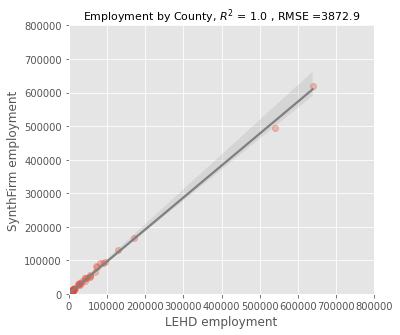

In [8]:
# compare to LEHD data
#lehd_validation.head(5)
lehd_firm_by_county = lehd_validation.loc[lehd_validation['industry'] == '0']
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
# print(firm_in_study_area_by_county.head(5))

lehd_firm_by_county = lehd_firm_by_county.groupby('geography')[['EmpS']].mean()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     left_on = 'geography',
                                     right_on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'CBPZONE', 'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_county['LEHD employment'], 
                              firm_comparison_by_county['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_county['LEHD employment'], 
                  firm_comparison_by_county['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)
print(firm_comparison_by_county['SynthFirm employment'].sum())
print(rmse_emp, r2_emp)
plt.style.use('ggplot')
g = sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="SynthFirm employment", 
    height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, scatter_kws = {'alpha':0.3})
plt.xlim([0, 800000])
plt.ylim([0, 800000])
plt.title('Employment by County, $R^{2}$ = ' + str(r2_emp) + ' , RMSE =' + str(rmse_emp), fontsize = 11)
plt.savefig('plots/emp_by_county_validation.png', dpi = 200,
           bbox_inches = 'tight')

firm_comparison_by_county.head(5)

3076348.7500000005
3144499.5644305707


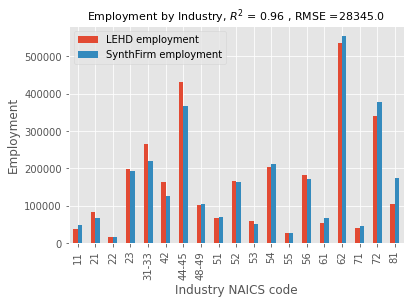

In [9]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = lehd_validation.loc[lehd_validation['industry'] != '0']

# print(lehd_firm_by_industry.industry.unique())

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['geography', 'industry'])[['EmpS']].mean()

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['geography'].isin(selected_counties)]

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['EmpS']].sum()
print(lehd_firm_by_industry['EmpS'].sum())

print(synthfirm_in_study_area.loc[:, 'Emp'].sum())
synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
# print(synthfirm_in_study_area.loc[:, 'NAICS2'].unique())
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'SynthFirm employment']
rmse_emp = mean_squared_error(firm_comparison_by_industry['LEHD employment'], 
                              firm_comparison_by_industry['SynthFirm employment'], squared = False)
r2_emp = r2_score(firm_comparison_by_industry['LEHD employment'], 
                  firm_comparison_by_industry['SynthFirm employment'])
rmse_emp = np.round(rmse_emp, 1)
r2_emp = np.round(r2_emp, 2)

# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('ggplot')
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry")
plt.xlabel('Industry NAICS code')
plt.ylabel('Employment')
plt.title('Employment by Industry, $R^{2}$ = ' + str(r2_emp) + ' , RMSE =' + str(rmse_emp), fontsize = 11)
plt.savefig('plots/emp_by_industry_validation.png', dpi = 200, bbox_inches = 'tight')

In [11]:
firm_in_region = firm_by_zone.loc[firm_by_zone['FAFID'].isin([481])]
region_map_with_firm = region_map.merge(firm_in_region, on='MESOZONE', how='inner')
region_map_with_firm.loc[:, 'firm_per_area'] = \
region_map_with_firm.loc[:, 'firm_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.loc[:, 'emp_per_area'] = \
region_map_with_firm.loc[:, 'employment_count'] / region_map_with_firm.loc[:, 'area']
region_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,area,firm_count,employment_count,Unnamed: 0,GEOID_y,CBPZONE_y,FAFID,FAFNAME,firm_per_area,emp_per_area
0,484530013052,48453,5676.0,"MULTIPOLYGON (((-97.76898 30.24602, -97.76484 ...",0.610901,60,1312.496114,6,484530013052,48453,481,Austin,98.215529,2148.458324
1,484910213004,48491,6730.0,"MULTIPOLYGON (((-97.55494 30.73420, -97.55005 ...",308.099637,46,463.410814,18,484910213004,48491,481,Austin,0.149302,1.504094
2,484530017384,48453,5773.0,"MULTIPOLYGON (((-97.87594 30.21458, -97.87348 ...",1.262111,58,367.157922,20,484530017384,48453,481,Austin,45.954768,290.907880
3,484530018481,48453,5947.0,"MULTIPOLYGON (((-97.70157 30.42772, -97.70006 ...",0.864858,63,425.459305,49,484530018481,48453,481,Austin,72.844336,491.941277
4,482090103044,48209,3129.0,"MULTIPOLYGON (((-97.92493 29.89346, -97.92389 ...",0.487494,70,609.854381,81,482090103044,48209,481,Austin,143.591365,1250.997467


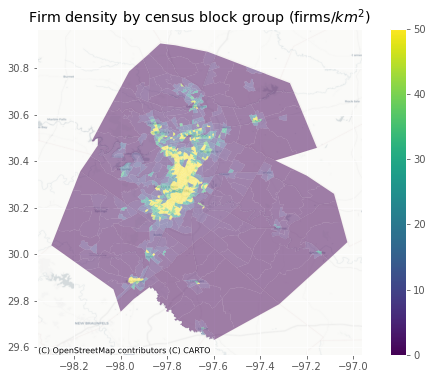

In [13]:
ax = region_map_with_firm.plot(figsize = (10,6), column = 'firm_per_area', 
                           vmin=0, vmax=50, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
plt.title('Firm density by census block group (firms/$km^{2}$)')
plt.savefig('plots/region_firm_count.png', dpi = 200)

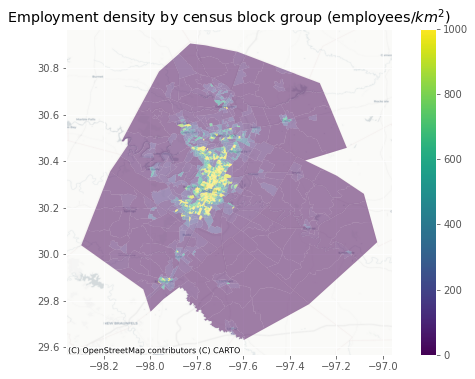

In [16]:
ax = region_map_with_firm.plot(figsize = (10,6), column = 'emp_per_area', 
                            vmin=0, vmax=1000, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.CartoDB.Positron)
plt.title('Employment density by census block group (employees/$km^{2}$)')
plt.savefig('plots/region_emp_count.png', dpi = 200)

In [17]:
# plot production
print(synthfirm_output.columns)
production_in_region = synthfirm_output.loc[synthfirm_output['orig_FAFID'].isin([481])]
production_in_region = production_in_region.groupby(['SellerZone'])[['ShipmentLoad']].sum()
production_in_region = production_in_region.reset_index()
production_in_region = production_in_region.rename(columns = {'SellerZone': 'MESOZONE'})

region_map_with_production = \
region_map.merge(production_in_region, on='MESOZONE', how='inner')
region_map_with_production.loc[:, 'production_per_area'] = \
region_map_with_production.loc[:, 'ShipmentLoad'] * 0.907185/ \
region_map_with_production.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
region_map_with_production.head(5)

Index(['Unnamed: 0', 'orig_FAFID', 'orig_FAFNAME', 'dest_FAFID',
       'dest_FAFNAME', 'SCTG_Group', 'SCTG_Name', 'mode_choice', 'tmiles',
       'ShipmentLoad', 'count', 'outbound', 'inbound', 'Distance'],
      dtype='object')


KeyError: 'SellerZone'

In [18]:
production_in_region.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
1127,1127,481,Austin,11,Birmingham,4,mfr_goods,For-hire Truck,1.093548e+06,1.274888,291,1,0,857.760000
1128,1128,481,Austin,11,Birmingham,4,mfr_goods,Rail/IMX,2.607898e+04,0.026212,6,1,0,994.940199
1129,1129,481,Austin,12,Mobile,3,interm_food,For-hire Truck,6.561531e+05,0.715551,28,1,0,916.990000
1130,1130,481,Austin,12,Mobile,3,interm_food,Rail/IMX,2.384587e+04,0.025951,1,1,0,918.880514
1131,1131,481,Austin,12,Mobile,4,mfr_goods,For-hire Truck,9.586375e+05,1.045418,211,1,0,916.990000


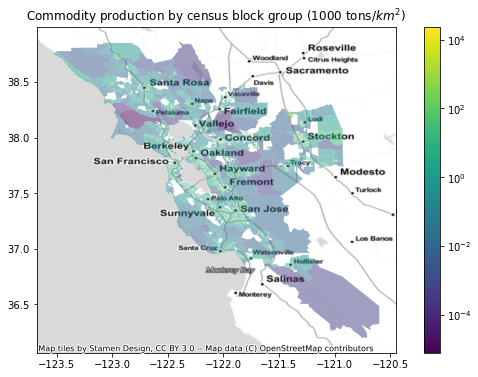

In [5]:
ax = sf_map_with_production.plot(figsize = (10,6), column = 'production_per_area', 
                            alpha = 0.5, legend=True,
                            norm=matplotlib.colors.LogNorm(vmin=sf_map_with_production.production_per_area.min(), 
                                                           vmax=sf_map_with_production.production_per_area.max()))
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Commodity production by census block group (1000 tons/$km^{2}$)')
plt.savefig('plots_SF/region_production_allmodes.png', dpi = 200)

In [6]:
# print(synthfirm_output.columns)
attraction_in_region = synthfirm_output.loc[synthfirm_output['dest_FAFID'].isin([64])]
attraction_in_region = attraction_in_region.groupby(['BuyerZone'])[['ShipmentLoad']].sum()
attraction_in_region = attraction_in_region.reset_index()
attraction_in_region = attraction_in_region.rename(columns = {'BuyerZone': 'MESOZONE'})

sf_map_with_attraction = sf_map.merge(attraction_in_region, on='MESOZONE', how='inner')
sf_map_with_attraction.loc[:, 'attraction_per_area'] = \
sf_map_with_attraction.loc[:, 'ShipmentLoad'] * 0.907185/ \
sf_map_with_attraction.loc[:, 'area']
# sf_map_with_firm.loc[:, 'emp_per_area'] = sf_map_with_firm.loc[:, 'employment_count'] / sf_map_with_firm.loc[:, 'area']
sf_map_with_attraction.head(5)

,GEOID,CBPZONE,MESOZONE,geometry,area,ShipmentLoad,attraction_per_area
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",2.303287,18.524643,7.296215
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",0.092171,253.765728,2497.656575
2,060014227001,6001,394.0,"MULTIPOLYGON (((-122.24986 37.86749, -122.2484...",0.184157,41.300247,203.451460
3,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",0.054842,151.315946,2503.030763
4,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",0.188182,41.376856,199.469335


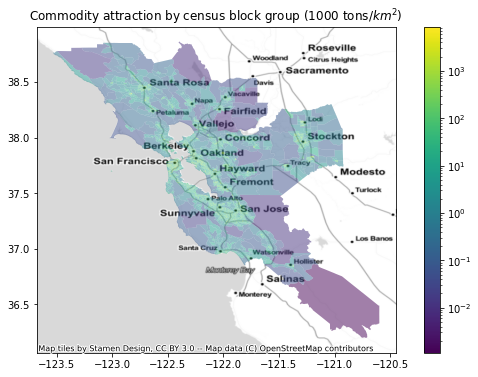

In [7]:
ax = sf_map_with_attraction.plot(figsize = (10,6), column = 'attraction_per_area', 
                            alpha = 0.5, legend=True,
                            norm=matplotlib.colors.LogNorm(vmin=sf_map_with_attraction.attraction_per_area.min(), 
                                                           vmax=sf_map_with_attraction.attraction_per_area.max()))
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Commodity attraction by census block group (1000 tons/$km^{2}$)')
plt.savefig('plots_SF/region_attraction_allmodes.png', dpi = 200)